In [16]:
# If you want to run on DRA
# !python3 -m venv ~/venvs/torch
# !~/venvs/torch/bin/python -m pip install --upgrade pip
# !~/venvs/torch/bin/python -m pip install torch torchvision
# !~/venvs/torch/bin/python -m pip install ipykernel
# !~/venvs/torch/bin/python -m ipykernel install --user --name torch --display-name "Python (torch)"
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scipy seaborn joblib

In [17]:
from dataclasses import dataclass
from types import SimpleNamespace
from typing import Optional, Tuple, Dict
import os, time, math
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
import itertools
import ellipse_mean_stable as em
import coin_press_2 as cp
import Huber_GDP as hg
import instance_opt_method as iom

In [18]:
# T = int(np.log(n))
# model = hg.robust_mean.m_est(x)
# # 2rho = epsilon^2 => epsilon=sqrt(2rho)
# priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = T)
# priv_mean

In [19]:
# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed: int, device: str):
    torch.manual_seed(seed)
    if device.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)


def make_spd_cov(d: int, device: str, dtype: torch.dtype, seed: int = 0):
    """Random SPD covariance with moderate conditioning."""
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    B = torch.randn(d,d, generator=g, device=device, dtype=dtype)
    Sigma = (B @ B.T) / d + 0.2 * torch.eye(d, device=device, dtype=dtype)
    return Sigma


def maha_error(mu_hat: torch.Tensor, mu_true: torch.Tensor, Sigma_true: torch.Tensor) -> float:
    """Mahalanobis norm ||mu_hat - mu||_{Sigma^{-1}}."""
    delta = (mu_hat - mu_true).to(Sigma_true.device, Sigma_true.dtype)
    Sinv = torch.linalg.inv(Sigma_true)
    val = delta @ Sinv @ delta
    return float(torch.sqrt(torch.clamp(val, min=0.0)).item())


In [20]:
# Data generators
# -----------------------------
@torch.no_grad()
def sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    return mu_true.unsqueeze(0) + Z @ L.T


@torch.no_grad()
def sample_banana(n, d, mu_true, Sigma_true,
                  device, dtype, seed, b=0.2):
    """
    Banana-shaped distribution:
      Start with Y ~ N(0, Sigma_true), then warp:
        X1 = Y1
        X2 = Y2 + b*(Y1^2 - E[Y1^2])
      and keep remaining coords as-is.
    This is strongly non-elliptical (curved level sets).
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Y = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T

    # Warp in first two coordinates
    y1 = Y[:, 0]
    y2 = Y[:, 1]
    # Center the quadratic term so mean stays controlled
    y1_var = torch.var(y1, unbiased=False)
    Y[:, 1] = y2 + b * (y1**2 - y1_var)

    return mu_true.view(1, d) + Y



@torch.no_grad()
def sample_skewed(n, d, mu_true, Sigma_true, skew_dir, skew_scale,
                  device, dtype, seed):
    """
    skew_dir   : (d,) direction of skew (unit vector recommended)
    skew_scale : scalar controlling skew strength
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)

    # Latent skew variable
    U = torch.randn(n, 1, generator=g, device=device, dtype=dtype)
    skew = skew_scale * torch.relu(U) * skew_dir.view(1, -1)

    X = Z @ L.T + skew
    return mu_true.unsqueeze(0) + X



@torch.no_grad()
def sample_contaminated_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed,
                                eta=0.1, shift_scale=8.0, inflate=3.0):
    """
    Huber contamination: (1-eta) N(mu, Sigma) + eta N(mu + shift, inflate*Sigma).
    shift direction is random but fixed per seed.
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    # clean
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    X_clean = mu_true.unsqueeze(0) + Z @ L.T

    # contam mask
    mask = (torch.rand(n, generator=g, device=device) < eta)
    m = int(mask.sum().item())
    if m == 0:
        return X_clean

    # contamination distribution
    # random shift direction
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    v = v / torch.linalg.norm(v).clamp_min(1e-12)
    shift = shift_scale * v  # magnitude

    Sigma_cont = inflate * Sigma_true
    Lc = torch.linalg.cholesky(Sigma_cont)
    Zc = torch.randn(m, d, generator=g, device=device, dtype=dtype)
    X_cont = (mu_true + shift).unsqueeze(0) + Zc @ Lc.T

    X = X_clean.clone()
    X[mask] = X_cont
    return X


@torch.no_grad()
def sample_multivariate_t(n, d, mu_true, Sigma_true, device, dtype, seed, df=3.0):
    """
    Multivariate t via scale-mixture:
      X = mu + Z / sqrt(U/df),  Z ~ N(0,Sigma), U ~ ChiSquare(df)
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T  # N(0,Sigma)

    # Chi-square(df) can be sampled via Gamma(k=df/2, theta=2)
    # U ~ Gamma(df/2, 2)
    U = torch.distributions.Gamma(concentration=df/2.0, rate=0.5).sample((n,)).to(device=device, dtype=dtype)
    scale = torch.sqrt(U / df).clamp_min(1e-12)  # (n,)

    X = mu_true.unsqueeze(0) + Z / scale.unsqueeze(1)
    return X



In [21]:
def random_skew_dir(d, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    return v / torch.norm(v)

In [22]:

def _device():
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def generate_data(dist, n, d, device, dtype, seed,
                  eta=0.1, shift_scale=8.0, inflate=3.0,
                  skew_scale=1.0):
    mu_true = torch.ones(d, device=device, dtype=dtype)
    Sigma_true = make_spd_cov(d, device=device, dtype=dtype, seed=seed + 17)

    if dist == "gaussian":
        X = sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed)

    elif dist == "contam_gaussian":
        X = sample_contaminated_gaussian(
            n, d, mu_true, Sigma_true,
            device, dtype, seed,
            eta=eta, shift_scale=shift_scale, inflate=inflate
        )

    elif dist == "t3":
        X = sample_multivariate_t(
            n, d, mu_true, Sigma_true,
            device, dtype, seed, df=3.0
        )

    elif dist == "skewed":
        # I want to try something else ,, 
        # g = torch.Generator(device=device)
        # g.manual_seed(seed + 999)
        # v = torch.randn(d, generator=g, device=device, dtype=dtype)
        # v = v / torch.linalg.norm(v).clamp_min(1e-12)
        # X = sample_skewed(
        #     n, d, mu_true, Sigma_true,
        #     skew_dir=v, skew_scale=skew_scale,
        #     device=device, dtype=dtype, seed=seed
        # )
        X = sample_banana(
            n, d, mu_true, Sigma_true,
            device=device, dtype=dtype, seed=seed, b=0.2)
    else:
        raise ValueError(dist)

    return X, mu_true, Sigma_true



In [23]:

def run_simulation(
    d_grid,
    n_grid,
    rho_grid, 
    dist_grid=("gaussian", "contam_gaussian", "t3", "skewed"),
    reps=20,
    dtype=torch.float32,
    seed0=1234,
    out_path="mean_comparison_simulation.csv",
    # generator params
    eta=0.1, shift_scale=2.0, inflate=3.0, skew_scale=4.0,
):
    device = _device()
    print(f"Running on {device}")

    rows = []

    for d in d_grid:
        sqd = torch.sqrt(torch.tensor(float(d), device=device, dtype=dtype))
        r = 50.0 * sqd
        u = 50.0 * sqd
        R_max = 50.0 * sqd

        nm = torch.tensor([1/3.0, 1/2.0, 1.0], device=device, dtype=dtype)
        nm = nm / nm.sum()

        for n in n_grid:
            for dist in dist_grid:
                for rho in rho_grid:  
                    print('on dist ',dist,'on n ',n, ' on d ',d,' on rho ',rho)
                    for rep in range(reps):
                        # seeding
                        rho_tag = int(round(1e6 * float(rho)))
                        seed = seed0 + 1_000_000 * rep + 10_000 * d + n + 31 * rho_tag

                        X, mu_true, Sigma_true = generate_data(
                            dist, n, d, device, dtype, seed,
                            eta, shift_scale, inflate, skew_scale
                        )

                        init = torch.zeros(d, device=device, dtype=dtype)

                        # ---- Sample mean (non-private baseline; rho irrelevant)
                        mu_mean = X.mean(dim=0)
                        err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                        # ---- Private ellipse
                        try:
                            mu_ell = em.private_ellipse_iteration(
                                X,
                                rho_total=float(rho),
                                r=r,
                                iters=3,
                                init=init,
                                R_min=1.0,
                                R_max=R_max,
                                thresholds=(0.9, 0.9, 0.9),
                                beta=1.01,
                                Sigma_unknown= False,
                                Sigma = Sigma_true,
                                max_iter=100000,
                            )
                            err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                        except Exception:
                            err_ell = float("nan")


                        # ---- Private ellipse trimmed aggro
                        try:
                            mu_ell = em.private_ellipse_iteration(
                                X,
                                rho_total=float(rho),
                                r=r,
                                iters=3,
                                init=init,
                                R_min=1.0,
                                R_max=R_max,
                                thresholds=(0.7, 0.6,0.5),
                                beta=1.01,
                                Sigma_unknown= False,
                                Sigma = Sigma_true,
                                max_iter=100000,
                            )
                            err_ell_rob = maha_error(mu_ell, mu_true, Sigma_true)
                        except Exception:
                            err_ell_rob = float("nan")


                        # ---- COINPRESS
                        try:
                            mu_cp = cp.COINPRESS(
                                X=X,
                                rho=float(rho),
                                c=init,
                                r=R_max,
                                u=float(u),
                                t=3,
                                nm=nm,
                                Sigma_unknown= False,
                                Sigma = Sigma_true,
                                beta=0.001,
                            )[0]
                            err_cp = maha_error(mu_cp, mu_true, Sigma_true)
                        except Exception:
                            err_cp = float("nan")
                        
                        ### Private Huber GDP
                        try:
                            model = hg.m_est(X.detach().cpu().numpy())
                            priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = math.sqrt(2*rho), T = int(math.log(n)))
                            err_huber = maha_error(torch.tensor(priv_mean, device=device), mu_true, Sigma_true)
                        except Exception:
                            err_huber = float("nan")

                        ## -- IOMean
                        try:
                            x_cpu=X.detach().cpu().numpy()
                            mu_iom = iom.random_rotation_mean(
                                        x=x_cpu,
                                        d=int(d),
                                        u=R_max.cpu().numpy(),
                                        p=float(rho)
                                    )
                            err_iom = maha_error(torch.from_numpy(mu_iom).to(X.device), mu_true, Sigma_true)
                                ###
                        except Exception:
                            err_iom = float("nan")

                        rows.append({
                            "dist": dist,
                            "n": int(n),
                            "d": int(d),
                            "rep": int(rep),
                            "rho": float(rho),
                            "mh_mean": float(err_mean),                        
                            "mh_ellipse": float(err_ell),
                            "mh_ellipse_rob": float(err_ell_rob),
                            "mh_coinpress": float(err_cp),
                            "mh_iom": float(err_iom),
                            "mh_huber": float(err_huber),
                            "eta": float(eta),
                        })


    df = pd.DataFrame(rows)
    df.to_csv(out_path, index=False)
    print(f"Saved {len(df)} rows to {out_path}")
    return df

In [ ]:
# Testing

# d_grid = [2, 8]
# n_grid = [100,200]
# rho_grid= [1]
# df = run_simulation( d_grid, n_grid,rho_grid,out_path="mean_comparison_rep_2.csv", reps=2)

In [24]:

# d_grid = [2, 5, 15, 50, 100]
d_grid_pow2 = [2, 8, 16, 64, 128]
n_grid = [250, 500, 2000, 5000]
rho_grid= [0.01,0.1,1]
df = run_simulation( d_grid_pow2, n_grid,rho_grid,out_path="mean_comparison_200_d_p_2.csv", reps=200)

Running on cuda
on dist  gaussian on n  250  on d  2  on rho  0.01
on dist  gaussian on n  250  on d  2  on rho  0.1
on dist  gaussian on n  250  on d  2  on rho  1
on dist  contam_gaussian on n  250  on d  2  on rho  0.01
on dist  contam_gaussian on n  250  on d  2  on rho  0.1
on dist  contam_gaussian on n  250  on d  2  on rho  1
on dist  t3 on n  250  on d  2  on rho  0.01
on dist  t3 on n  250  on d  2  on rho  0.1
on dist  t3 on n  250  on d  2  on rho  1
on dist  skewed on n  250  on d  2  on rho  0.01
on dist  skewed on n  250  on d  2  on rho  0.1
on dist  skewed on n  250  on d  2  on rho  1
on dist  gaussian on n  500  on d  2  on rho  0.01
on dist  gaussian on n  500  on d  2  on rho  0.1
on dist  gaussian on n  500  on d  2  on rho  1
on dist  contam_gaussian on n  500  on d  2  on rho  0.01
on dist  contam_gaussian on n  500  on d  2  on rho  0.1
on dist  contam_gaussian on n  500  on d  2  on rho  1
on dist  t3 on n  500  on d  2  on rho  0.01
on dist  t3 on n  500  on d

In [25]:
df=pd.read_csv("mean_comparison_200_d_p_2.csv")
df.head()


,dist,n,d,rep,rho,mh_mean,mh_ellipse,mh_ellipse_rob,mh_coinpress,mh_iom,mh_huber,eta
0,gaussian,250,2,0,0.01,0.098425,0.571347,0.222697,4.404316,0.278910,2.650384,0.1
1,gaussian,250,2,1,0.01,0.083260,0.164889,0.139346,4.797647,0.681123,0.576770,0.1
2,gaussian,250,2,2,0.01,0.051040,0.151651,0.580466,7.591463,0.231982,1.294913,0.1
3,gaussian,250,2,3,0.01,0.103052,0.597235,0.156922,5.054272,0.376923,0.854831,0.1
4,gaussian,250,2,4,0.01,0.077148,21.854105,0.122843,3.860861,2.547752,1.135919,0.1


In [26]:
# df = (
#     df
#     .groupby(["dist", "n", "d","rho"], as_index=False)
#     .median(numeric_only=True)
# )
# df
# df=df
df= df.rename(columns={"rho": "ρ"})
df= df.rename(columns={"mh_huber": "Huber"})
df= df.rename(columns={"mh_ellipse": "Balloon mean (high τ)"})
df= df.rename(columns={"mh_ellipse_rob": "Balloon mean (low τ)"})
df= df.rename(columns={"mh_coinpress": "Coinpress"})
df= df.rename(columns={"mh_iom": "IO mean"})
dist_map = {
    "gaussian": "Gaussian",
    "contam_gaussian": "Contam. Gaussian",
    "skewed": "Banana-shaped",
    "t3": r"$t_3$"
}

df["dist"] = df["dist"].replace(dist_map)

In [27]:
df.groupby(["dist","d","n","ρ"])['rep'].count().describe()

count    240.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: rep, dtype: float64

In [28]:

plot_df = df.melt(
    id_vars=["n","dist","d","ρ"],
    value_vars=["Balloon mean (high τ)","Balloon mean (low τ)","Coinpress","Huber","IO mean"],
    var_name="estimator",
    value_name="error"
)

plot_df.groupby(["dist","d","n","ρ","estimator"])["error"].describe()["std"]

dist      d    n     ρ     estimator            
$t_3$     2    250   0.01  Balloon mean (high τ)    0.192000
                           Balloon mean (low τ)     0.167084
                           Coinpress                2.300326
                           Huber                    0.627137
                           IO mean                  1.645448
                                                      ...   
Gaussian  128  5000  1.00  Balloon mean (high τ)    0.011101
                           Balloon mean (low τ)     0.011088
                           Coinpress                0.011557
                           Huber                    0.102648
                           IO mean                  0.011869
Name: std, Length: 1200, dtype: float64

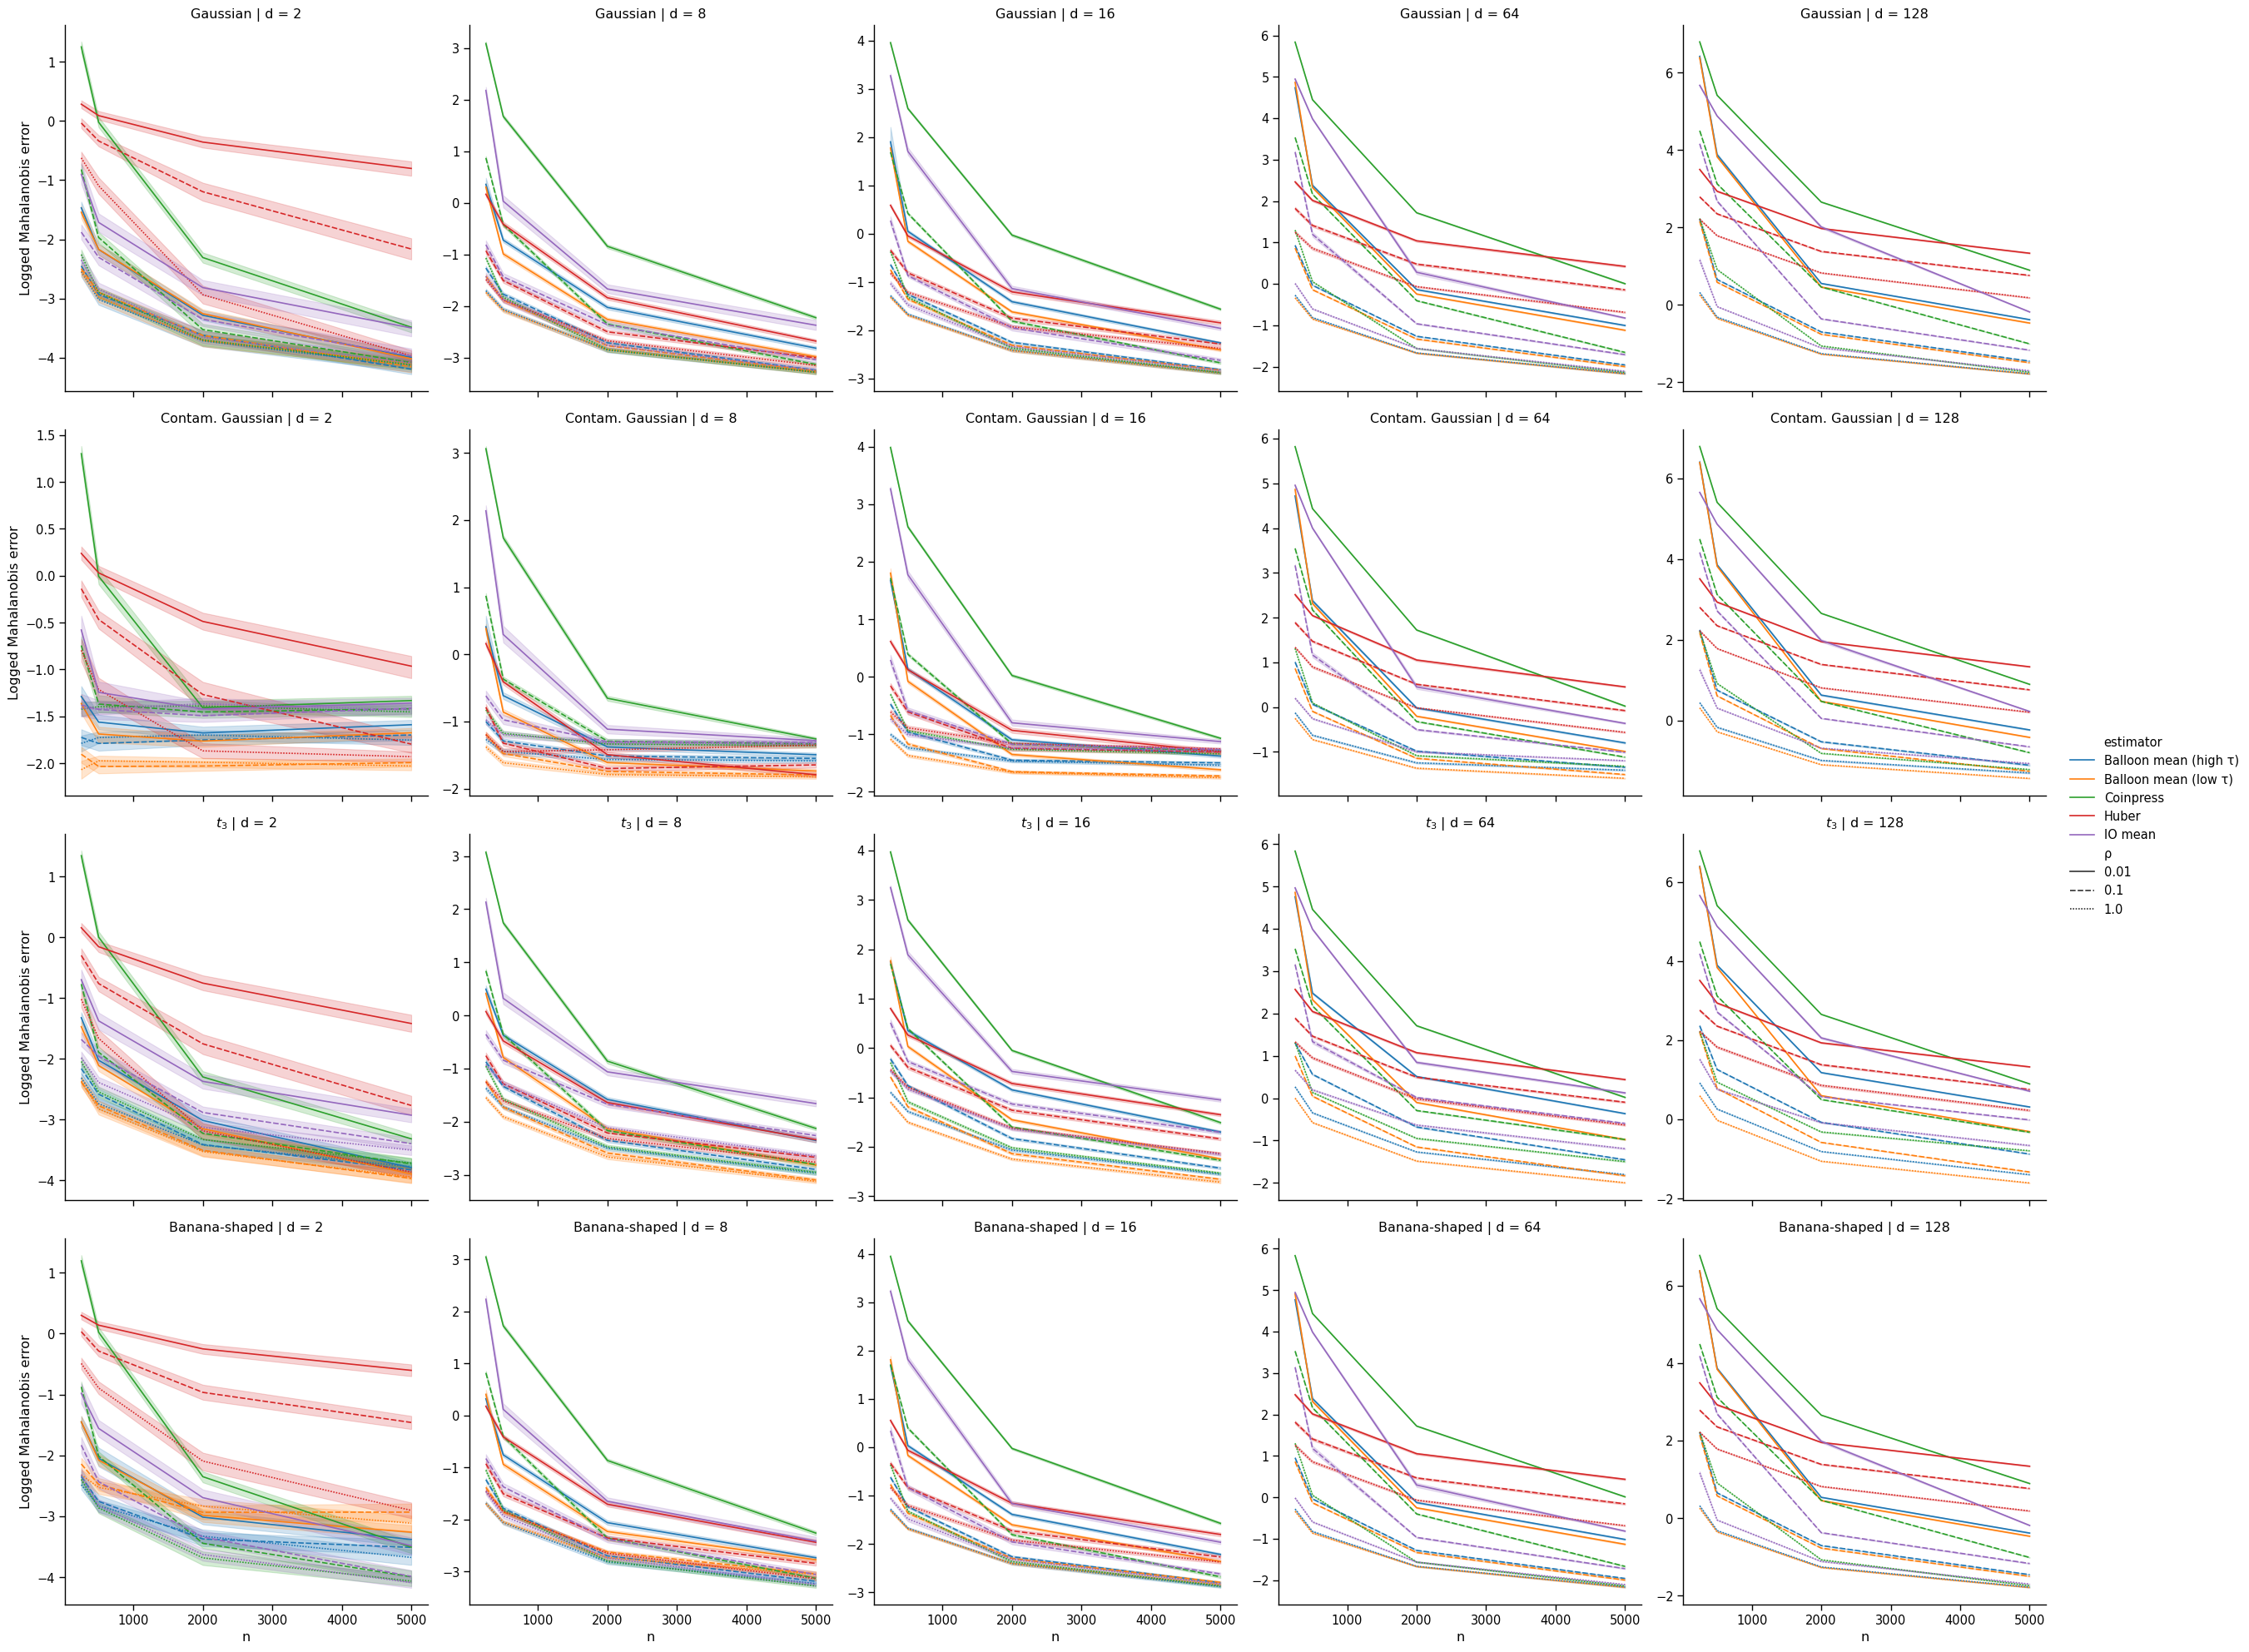

In [29]:

plot_df= plot_df.rename(columns={"dist": "Distribution"})
plot_df['log_error']=plot_df["error"].apply(np.log)
# "mh_mean"
g = sns.relplot(
    data=plot_df,
    x="n",
    y="log_error",
    hue="estimator",
    col="d",
    row="Distribution",
    style="ρ",
    kind="line",
    # marker="o",
    errorbar=("ci",95),
    facet_kws=dict(sharey=False),
    marker=None
)
# remove default left labels
g.set_ylabels("")
g.set_titles(row_template="{row_name}", col_template="d = {col_name}")
# 
for ax in g.axes[:, 0]:
    ax.set_ylabel("Logged Mahalanobis error")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()


g.savefig("Results.png", dpi=500, bbox_inches="tight")
plt.show()


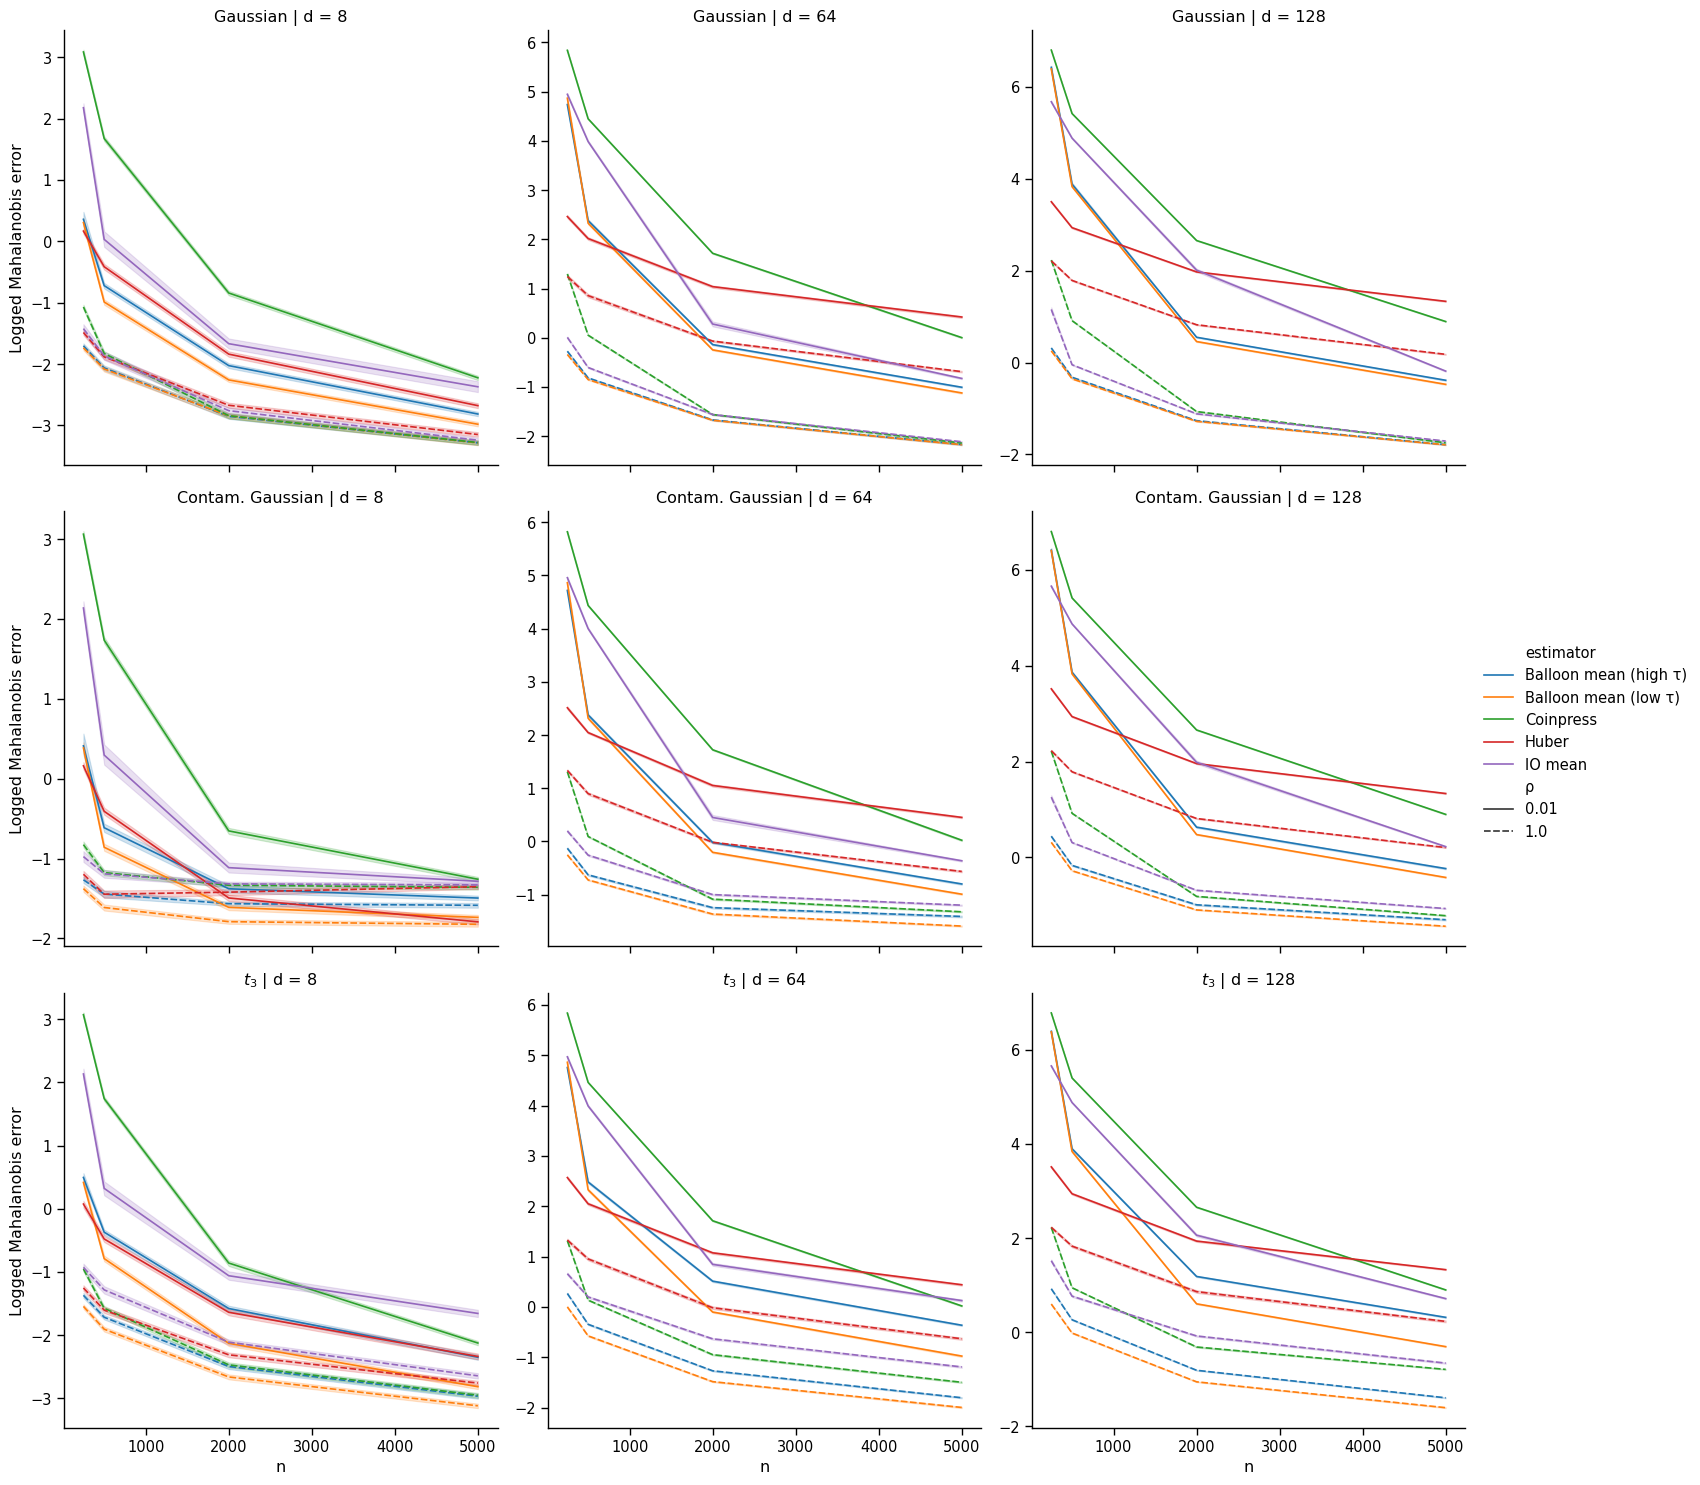

In [30]:

d_keep = [8, 64, 128]  

# Rows 
dist_keep = ["Gaussian", "Contam. Gaussian", r"$t_3$"]  
small_df = (
    plot_df.loc[
        plot_df["d"].isin(d_keep) & plot_df["Distribution"].isin(dist_keep)
    ]
    .copy()
)


small_df["d"] = pd.Categorical(small_df["d"], categories=d_keep, ordered=True)
small_df["Distribution"] = pd.Categorical(
    small_df["Distribution"], categories=dist_keep, ordered=True
)
small_df["ρ"] = pd.Categorical(small_df["ρ"], categories=[0.01,1], ordered=True)
sns.set_context("paper", font_scale=1.2)


# "mh_mean"
g = sns.relplot(
    data=small_df,
    x="n",
    y="log_error",
    hue="estimator",
    col="d",
    row="Distribution",
    style="ρ",
    kind="line",
    # marker="o",
    errorbar=("ci",95),
    facet_kws=dict(sharey=False),
    marker=None
)
# remove default left labels
g.set_ylabels("")
g.set_titles(row_template="{row_name}", col_template="d = {col_name}")
# rightmost column axes
for ax in g.axes[:, 0]:
    ax.set_ylabel("Logged Mahalanobis error")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
g.savefig("Results_Small.png", dpi=500, bbox_inches="tight")
plt.show()